In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
import seaborn as sns
from sentence_transformers import SentenceTransformer
import hdbscan
import re

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [ ]:
df = pd.read_csv('financial_loan.csv')
df

,id,address_state,application_type,emp_length,emp_title,grade,home_ownership,issue_date,last_credit_pull_date,last_payment_date,...,sub_grade,term,verification_status,annual_income,dti,installment,int_rate,loan_amount,total_acc,total_payment
0,1077430,GA,INDIVIDUAL,< 1 year,Ryder,C,RENT,11-02-2021,13-09-2021,13-04-2021,...,C4,60 months,Source Verified,30000.0,0.0100,59.83,0.1527,2500,4,1009
1,1072053,CA,INDIVIDUAL,9 years,MKC Accounting,E,RENT,01-01-2021,14-12-2021,15-01-2021,...,E1,36 months,Source Verified,48000.0,0.0535,109.43,0.1864,3000,4,3939
2,1069243,CA,INDIVIDUAL,4 years,Chemat Technology Inc,C,RENT,05-01-2021,12-12-2021,09-01-2021,...,C5,36 months,Not Verified,50000.0,0.2088,421.65,0.1596,12000,11,3522
3,1041756,TX,INDIVIDUAL,< 1 year,barnes distribution,B,MORTGAGE,25-02-2021,12-12-2021,12-03-2021,...,B2,60 months,Source Verified,42000.0,0.0540,97.06,0.1065,4500,9,4911
4,1068350,IL,INDIVIDUAL,10+ years,J&J Steel Inc,A,MORTGAGE,01-01-2021,14-12-2021,15-01-2021,...,A1,36 months,Verified,83000.0,0.0231,106.53,0.0603,3500,28,3835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38571,803452,NJ,INDIVIDUAL,< 1 year,Joseph M Sanzari Company,C,MORTGAGE,11-07-2021,16-05-2021,16-05-2021,...,C1,60 months,Verified,100000.0,0.1986,551.64,0.1299,24250,33,31946
38572,970377,NY,INDIVIDUAL,8 years,Swat Fame,C,RENT,11-10-2021,16-04-2021,16-05-2021,...,C1,60 months,Verified,50000.0,0.0458,579.72,0.1349,25200,18,31870
38573,875376,CA,INDIVIDUAL,5 years,Anaheim Regional Medical Center,D,RENT,11-09-2021,16-05-2021,16-05-2021,...,D5,60 months,Verified,65000.0,0.1734,627.93,0.1749,25000,20,35721
38574,972997,NY,INDIVIDUAL,5 years,Brooklyn Radiology,D,RENT,11-10-2021,16-05-2021,16-05-2021,...,D5,60 months,Verified,368000.0,0.0009,612.72,0.1825,24000,9,33677


## Подготовка датасета

Подготавливаем таргет, выкидываем признаки, неизвестные на момент выдачи кредита, и убираем ненужные модели признаки `id` и `member_id`.

In [ ]:
df = df[df['loan_status'] != 'Current'].copy()
df['target'] = (df['loan_status'] == 'Charged Off').astype(int)
df.drop(columns=['id', 'member_id', 'last_payment_date', 'next_payment_date', 'total_payment', 'last_credit_pull_date', 'loan_status'], inplace=True)
df

,address_state,application_type,emp_length,emp_title,grade,home_ownership,issue_date,purpose,sub_grade,term,verification_status,annual_income,dti,installment,int_rate,loan_amount,total_acc,target
0,GA,INDIVIDUAL,< 1 year,Ryder,C,RENT,11-02-2021,car,C4,60 months,Source Verified,30000.0,0.0100,59.83,0.1527,2500,4,1
1,CA,INDIVIDUAL,9 years,MKC Accounting,E,RENT,01-01-2021,car,E1,36 months,Source Verified,48000.0,0.0535,109.43,0.1864,3000,4,0
2,CA,INDIVIDUAL,4 years,Chemat Technology Inc,C,RENT,05-01-2021,car,C5,36 months,Not Verified,50000.0,0.2088,421.65,0.1596,12000,11,1
3,TX,INDIVIDUAL,< 1 year,barnes distribution,B,MORTGAGE,25-02-2021,car,B2,60 months,Source Verified,42000.0,0.0540,97.06,0.1065,4500,9,0
4,IL,INDIVIDUAL,10+ years,J&J Steel Inc,A,MORTGAGE,01-01-2021,car,A1,36 months,Verified,83000.0,0.0231,106.53,0.0603,3500,28,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38553,GA,INDIVIDUAL,4 years,PILOT OIL,F,RENT,11-05-2021,wedding,F4,60 months,Verified,70000.0,0.1809,436.11,0.2136,16000,5,0
38554,NY,INDIVIDUAL,2 years,Guardian Life Insurance Company,G,RENT,11-02-2021,wedding,G3,60 months,Verified,100000.0,0.1517,269.70,0.2085,10000,22,0
38555,CA,INDIVIDUAL,4 years,Advantage IT,G,RENT,11-03-2021,wedding,G1,60 months,Verified,85000.0,0.1392,424.89,0.2011,16000,12,0
38556,GA,INDIVIDUAL,10+ years,us postal service,B,RENT,10-08-2021,wedding,B4,60 months,Verified,48000.0,0.1175,65.97,0.1149,3000,18,0


In [ ]:
print(f'Доля невозвращенных кредитов: {df["target"].mean():.4f}')

Доля невозвращенных кредитов: 0.1423


## Кодирование признаков

In [ ]:
categorical_raw = ['address_state', 'application_type', 'emp_length', 'grade', 'home_ownership', 'purpose', 'sub_grade', 'term', 'verification_status']

In [ ]:
print('Количество уникальных значений для категориальных признаков')
for column in categorical_raw:
    print(f'    {column} : {df[column].nunique()}')

Количество уникальных значений для категориальных признаков
    address_state : 50
    application_type : 1
    emp_length : 11
    grade : 7
    home_ownership : 5
    purpose : 14
    sub_grade : 35
    term : 2
    verification_status : 3


Сразу заметим, что `application_type` можно убрать, так как он имеет одно значение, и признак `grade` можно убрать, так как он покрывается признаком `sub_grade`.
Логичнее всего для признаков с малым числом значений (`term`, `verification_status`, и `home_ownership`) применить OHE, `emp_length` и `sub_grade` кажутся важными признаками, но при этом у них есть определенный порядок, потому для них логично попробовать числовое кодирование, попробуем OE. На данном этапе не ясно, что делать c `purpose`, попробуем либо OHE, так как значений не так уж много, либо TE. Посмотрим на то, как устроен `address_state`

In [ ]:
categorical_features = ['term', 'verification_status', 'home_ownership']

In [ ]:
def plot_target_rate_by_category(df, categorical_col, target_col):
    target_rate: pd.Series = (
        df.groupby(categorical_col)[target_col]
        .mean()
        .sort_values(ascending=False)
    )
    counts = df[categorical_col].value_counts().loc[target_rate.index]

    fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    target_rate.plot(kind='bar', ax=ax[0])

    ax[0].set_ylabel('Target Rate (Share of 1)')
    ax[0].set_xlabel(categorical_col)
    ax[0].set_title(f'Target Rate by {categorical_col}')
    ax[0].tick_params(axis='x', rotation=90)

    ax[1].pie(
        counts,
        labels=counts.index,
        autopct='%1.1f%%'
    )
    ax[1].set_title('Category Distribution')

    plt.tight_layout()
    plt.show()


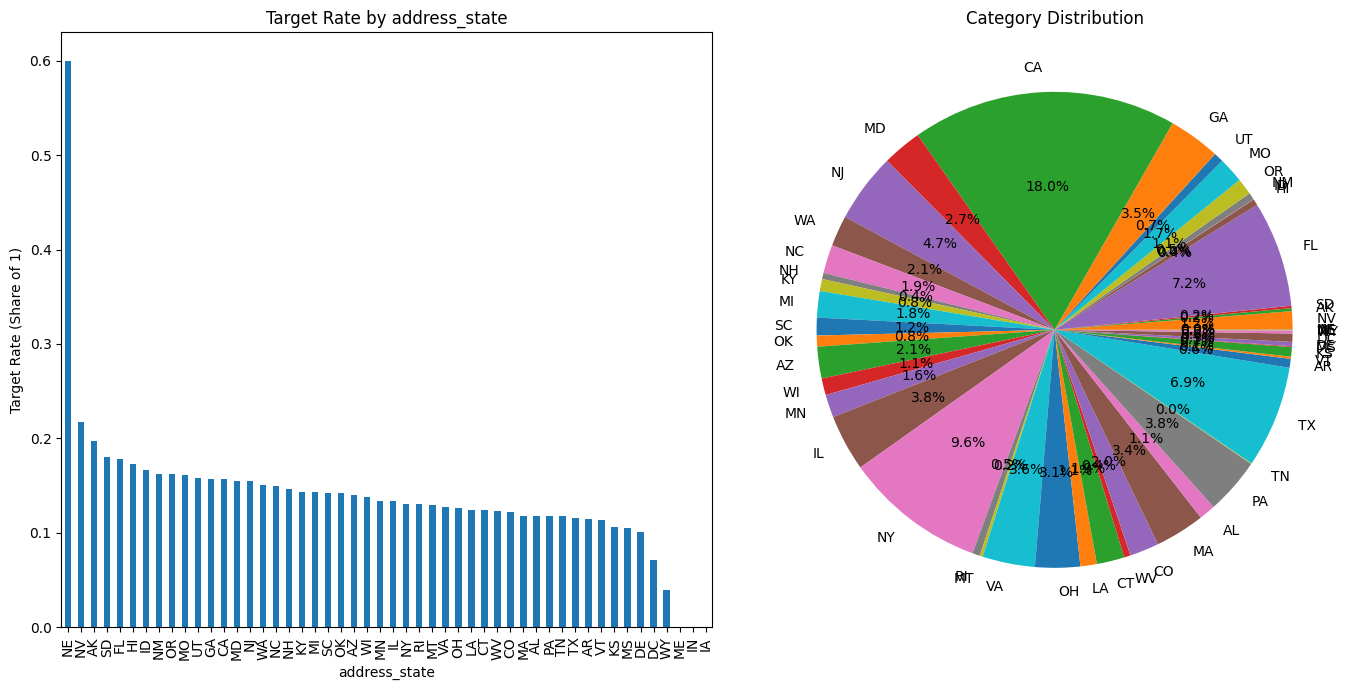

In [ ]:
plot_target_rate_by_category(df, 'address_state', 'target')

In [ ]:
sum(df['address_state'] == 'NE')

5

как мы видим, штат с аномальным числом фрода имеет очень мало вхождений в датасет, а потому нерепрезентативный. сжать штаты с малым числом вхождений в один `Other` кажется верным решением для избежания оверфита.

In [ ]:
state_counts = df['address_state'].value_counts()
state_counts_smallest_35 = state_counts.nsmallest(35).index
df['state_grouped'] = df['address_state'].replace(state_counts_smallest_35, 'Other')

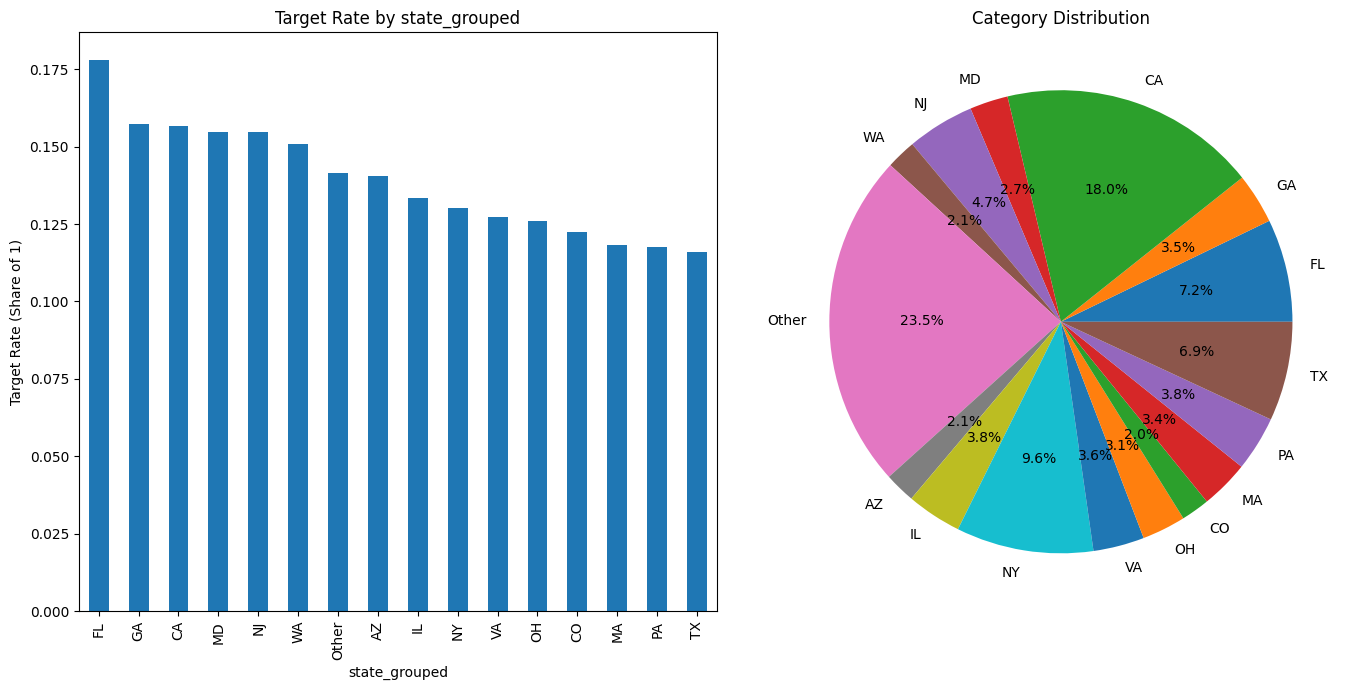

In [ ]:
plot_target_rate_by_category(df, 'state_grouped', 'target')

Теперь все логично и можно делать TE.

In [ ]:
categorical_features.append('state_grouped')

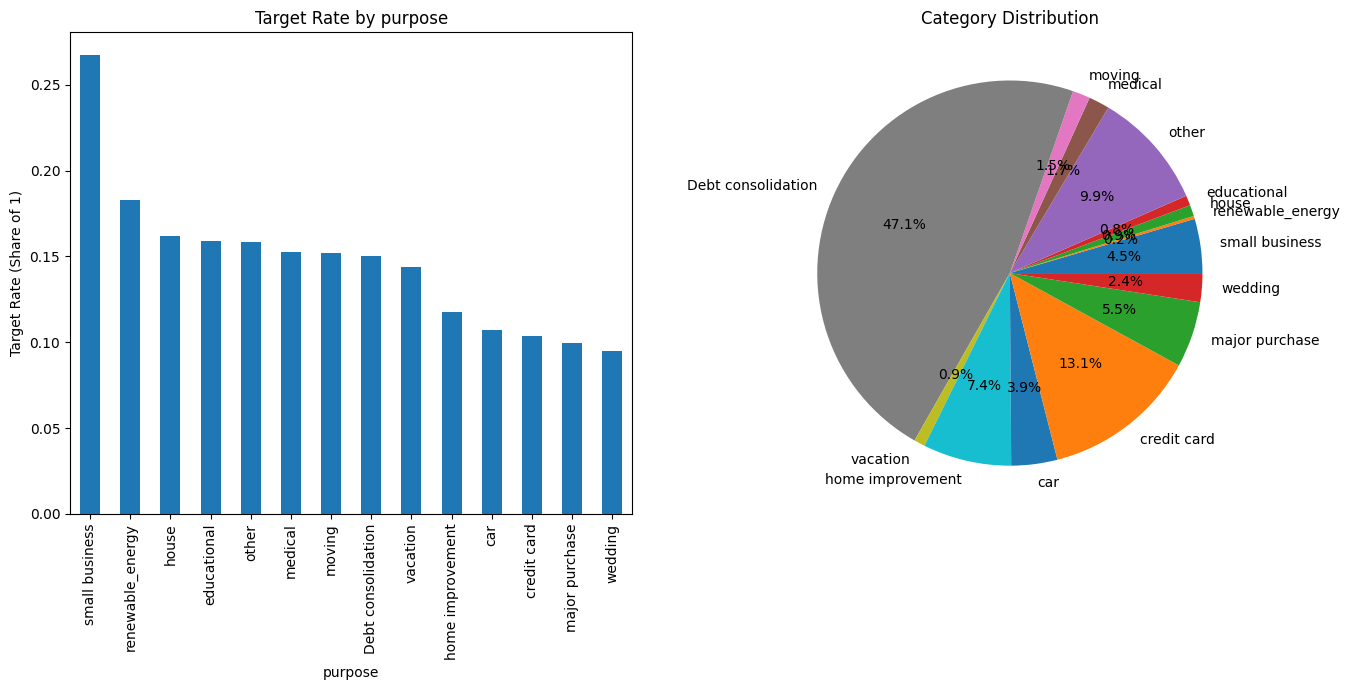

In [ ]:
plot_target_rate_by_category(df, 'purpose', 'target')

Обьединим малые категории в одну

In [ ]:
purpose_counts = df['purpose'].value_counts()
purpose_smallest_4 = purpose_counts.nsmallest(4).index
df['purpose_grouped'] = df['purpose'].replace(purpose_smallest_4, 'other')

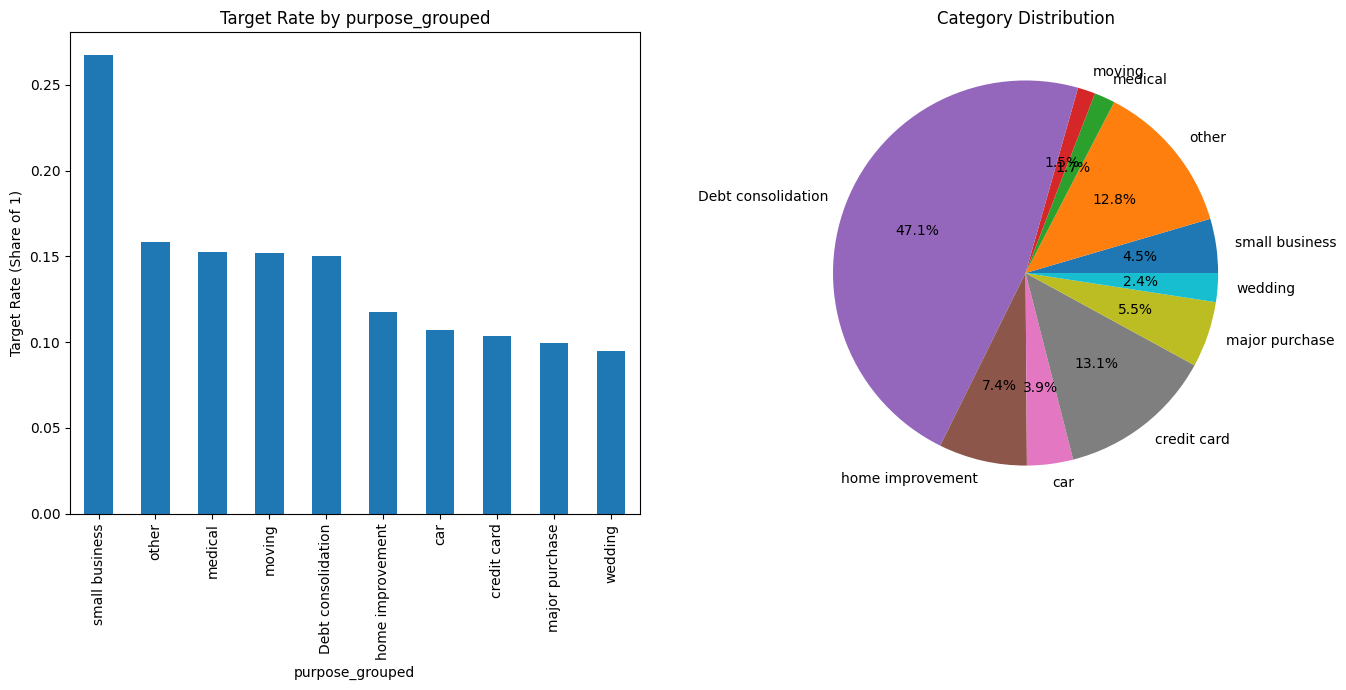

In [ ]:
plot_target_rate_by_category(df, 'purpose_grouped', 'target')

In [ ]:
categorical_features.append('purpose_grouped')

теперь выглядит лучше, осталось посмотреть на то, как распределен 'emp_length'

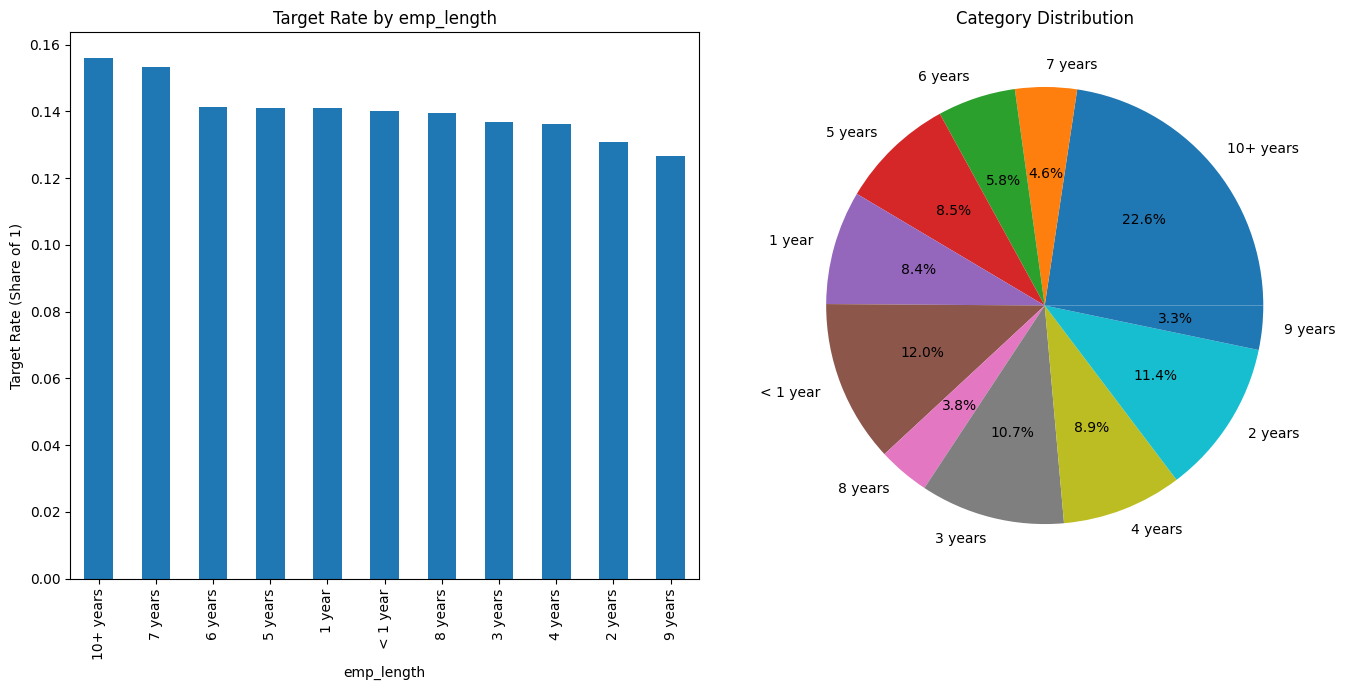

In [ ]:
plot_target_rate_by_category(df, 'emp_length', 'target')

Хотя кажется, что признак важный, на самом деле он довольно шумный и не сильно связан с таргетом, потому давайте его сгруппируем по бинам и закодируем OHE.

In [ ]:
df['emp_length'].unique()

array(['< 1 year', '9 years', '4 years', '10+ years', '3 years',
       '5 years', '1 year', '6 years', '2 years', '7 years', '8 years'],
      dtype=object)

In [ ]:
length_mapping = {
    '< 1 year': '< 1 year',
    '1 year': '1-5 years',
    '2 years': '1-5 years',
    '3 years': '1-5 years',
    '4 years': '1-5 years',
    '5 years': '1-5 years',
    '6 years': '6-9 years',
    '7 years': '6-9 years',
    '8 years': '6-9 years',
    '9 years': '6-9 years',
    '10+ years': '10+ years',
}

df['emp_length_bin'] = df['emp_length'].map(length_mapping)
df['emp_length_bin'].unique()

array(['< 1 year', '6-9 years', '1-5 years', '10+ years'], dtype=object)

In [ ]:
categorical_features.append('emp_length_bin')

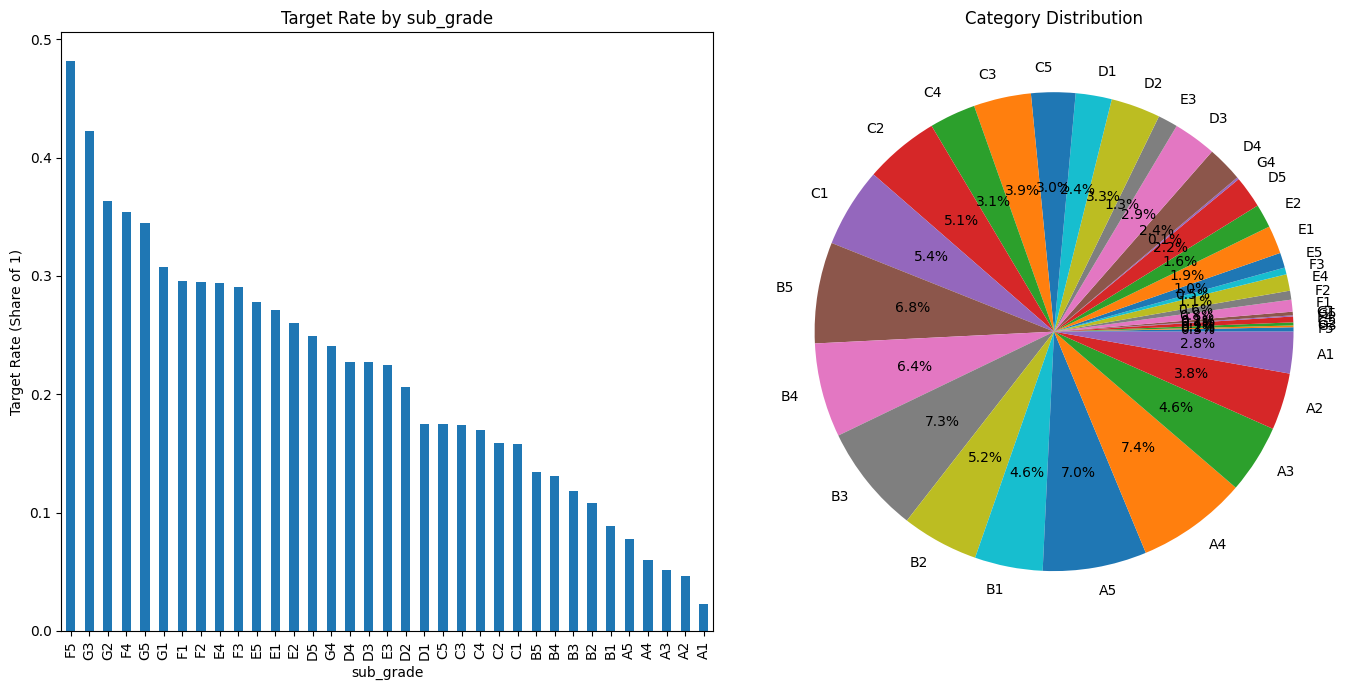

In [ ]:
plot_target_rate_by_category(df, 'sub_grade', 'target')

видим почти линейную зависимость, закодируем числами подряд:

In [ ]:
grades = ['A', 'B',  'C', 'D', 'E', 'F', 'G',]
grades_mapping = {}

counter = 1
for g in grades:
    for i in range(1, 6):
        grades_mapping[f"{g}{i}"] = counter
        counter += 1

df["sub_grade_num"] = df["sub_grade"].map(grades_mapping)

In [ ]:
categorical_features.append('sub_grade_num')

## Обработка `emp_title`

In [ ]:
df['emp_title'].sample(10)

16862              RNL Biostar  Inc
32570           rising star srvices
35725       WI Dept. of Corrections
10909                 Systemax inc.
17947           St. Luke's Hospital
3885                   Red Ventures
2917     Precision Steel Mfg. Corp.
2742           Annabelle's Pet Care
13490                        DuPont
32387                        NOVELL
Name: emp_title, dtype: object

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def normalize_employer(text):
    if pd.isna(text):
        return ""

    text = text.lower().strip()
    text = re.sub(r"\b(inc|llc|ltd|corp|corporation|co|company|gmbh|plc|sa|ооо|ао)\b\.?", "", text)
    text = re.sub(r"[^a-z0-9\s&]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    return text


def build_employer_clusters(df, col, n_clusters=150):
    df = df.copy()
    df[col] = df[col].apply(normalize_employer)

    undefined_mask = df[col] == ""

    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

    embeddings = model.encode(
        df[col].tolist(),
        batch_size=128,
        show_progress_bar=True,
        normalize_embeddings=True
    )

    kmeans = KMeans(
        n_clusters=150,
        random_state=42,
        n_init="auto"
    )

    print('Starting clustering')
    emb_reduced = PCA(n_components=50, random_state=42).fit_transform(embeddings)
    labels = kmeans.fit_predict(emb_reduced)
    labels[undefined_mask] = -2

    df[col + "_cluster"] = labels

    return df

In [ ]:
df = build_employer_clusters(df, 'emp_title')

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 1839.12it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 293/293 [00:14<00:00, 20.20it/s]


Starting clustering


In [ ]:
df[df['emp_title_cluster'] == 2]['emp_title'].sample(10)

15806                                     fda
32164                                 u s fda
3395                     bristol myers squibb
22208                     acorda therapeutics
30032                          giant pharmacy
35509                              par pharma
9140                              biobanc usa
2927                             novogradac &
16298    boehringer ingelheim pharmaceuticals
34751                             pharmathene
Name: emp_title, dtype: object

Результаты хорошие, в одном из запусков был кластер с разными фарма компаниями, где в названии было слово `pharma` или `pharmaceutical`, но также туда попал `bristol myers squibb`, а это фарма компания, в названии которой нет слова `pharma`, значит действительно кластеризовали хорошо и по смыслу, а не просто по словам, как TF-IDF

In [ ]:
categorical_features.append('emp_title_cluster')

## Числовые признаки

### annual_income

In [ ]:
def plot_hist(df, column, bins):
    plt.hist(df[column], bins=bins)
    plt.xlabel(column)
    plt.show()

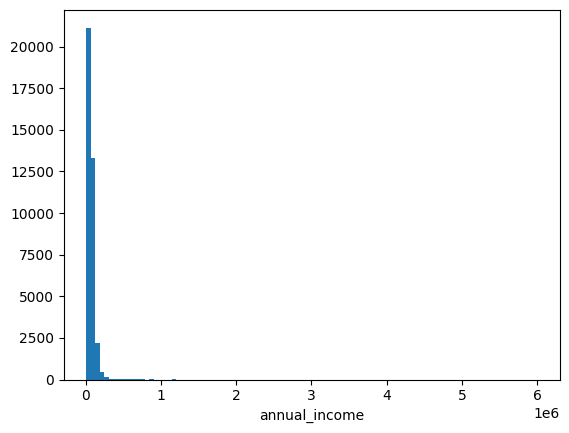

In [ ]:
plot_hist(df, 'annual_income', 100)

Распределение с очень тяжелым хвостом, можно отлогарифмировать

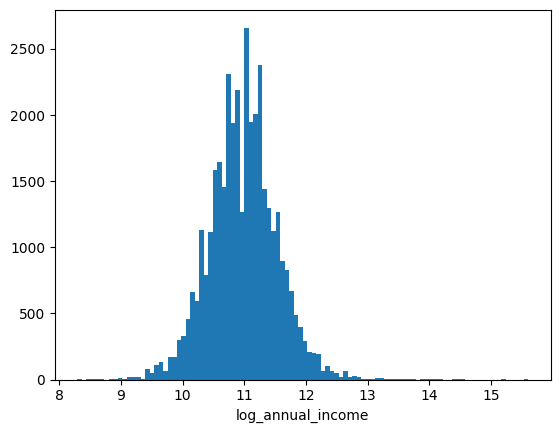

In [ ]:
df['log_annual_income'] = np.log1p(df['annual_income'])
plot_hist(df, 'log_annual_income', 100)

теперь распределение похоже на нормальное, только все равно надо убрать верхнюю часть из трейна, чтобы не было выбросов

### dti

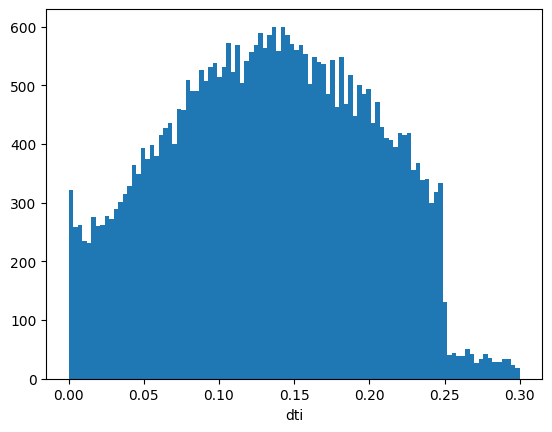

In [ ]:
plot_hist(df, 'dti', 100)

распределение не очень красивое, но пока оставим как есть

### installment

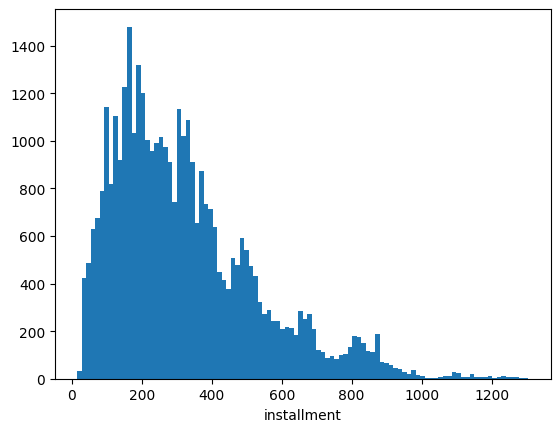

In [ ]:
plot_hist(df, 'installment', 100)

на глаз похоже на логнормальное, так что логарифмируем

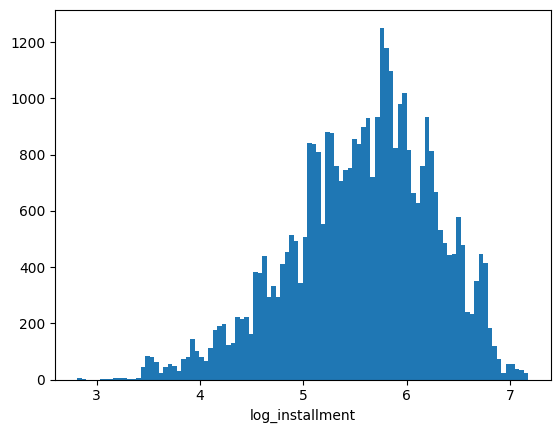

In [ ]:
df['log_installment'] = np.log1p(df['installment'])
plot_hist(df, 'log_installment', 100)



### int_rate

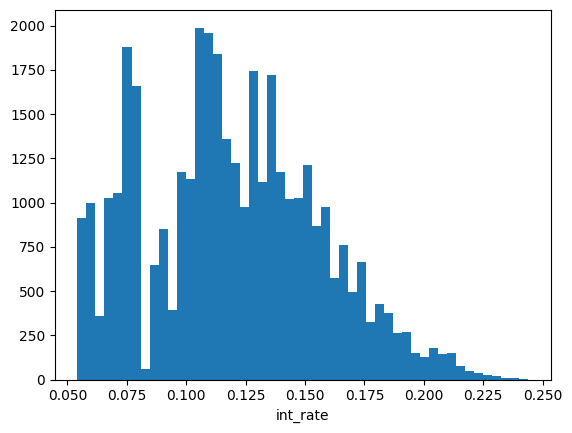

In [ ]:
plot_hist(df, 'int_rate', 50)

распредение выглядит адекватно, хвост не сильно тяжелый, но для дальнейшего анализа добавим и логарифм

In [ ]:
df['log_int_rate'] = np.log1p(df['int_rate'])

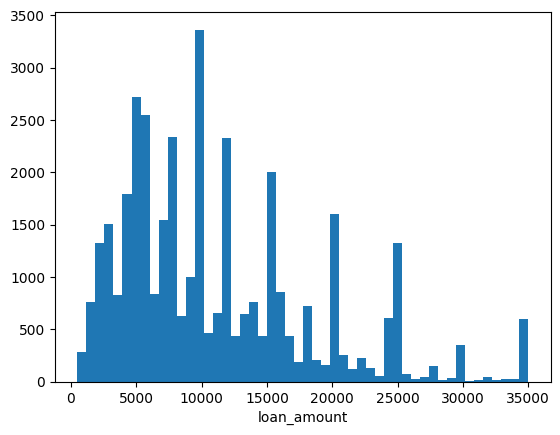

In [ ]:
plot_hist(df, 'loan_amount', 50)

In [ ]:
df['log_loan_amount'] = np.log1p(df['loan_amount'])

люди часто берут в долг круглую сумму, потому и распределение такое зубчатое

### total_acc

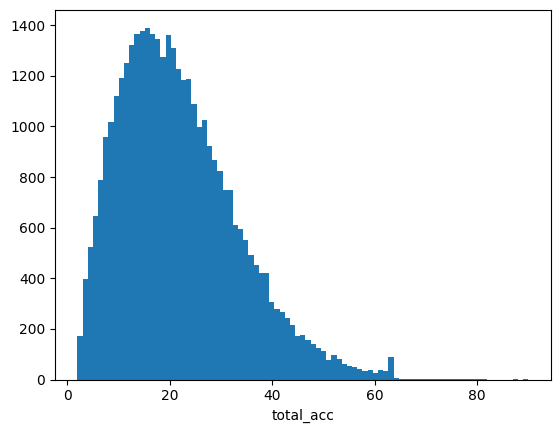

In [ ]:
plot_hist(df, 'total_acc', df['total_acc'].nunique() + 5)

In [ ]:
df['log_total_acc'] = np.log1p(df['total_acc'])

### Новые фичи

Добавим новые смысловые признаки

In [ ]:
df['loan_amount_to_income'] = df['loan_amount'] / df['annual_income']
df['installment_to_income'] = df['installment'] / df['annual_income']
df['log_loan_amount_to_income'] = np.log1p(df['loan_amount_to_income'])
df['log_installment_to_income'] = np.log1p(df['installment_to_income'])

In [ ]:
numerical_features_for_analysis = ['loan_amount_to_income',
                                   'log_loan_amount_to_income',
                                   'installment_to_income',
                                   'log_installment_to_income',
                                   'annual_income', 'log_annual_income',
                                   'dti', 'installment', 'log_installment',
                                   'int_rate', 'log_int_rate', 'loan_amount',
                                   'log_loan_amount', 'total_acc',  'log_total_acc']

/var/folders/fj/bc17zqqj71n5ms8n4wkhyg2h0000gn/T/ipykernel_37694/2261712643.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


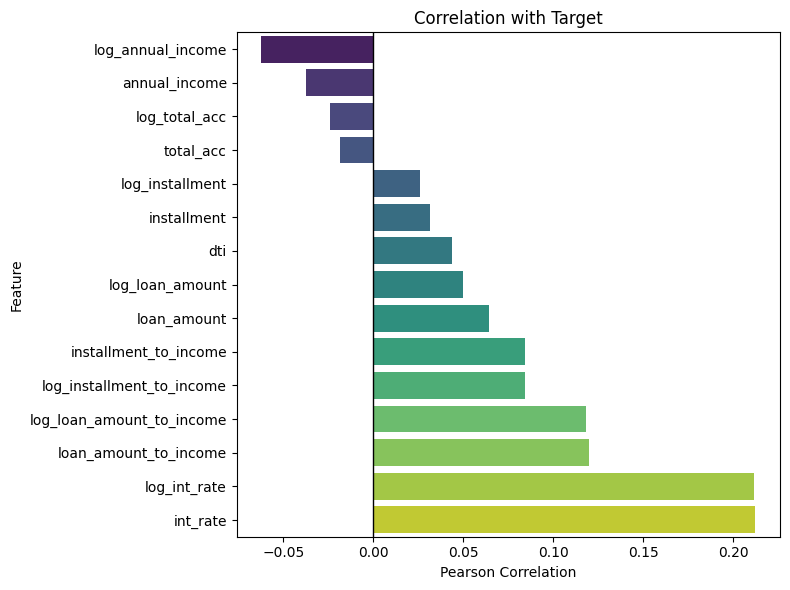

In [ ]:
corrs = (
    df[numerical_features_for_analysis + ["target"]]
    .corr()["target"]
    .drop("target")
    .sort_values()
)

plt.figure(figsize=(8, len(corrs) * 0.4))

sns.barplot(
    x=corrs.values,
    y=corrs.index,
    palette="viridis"
)

plt.axvline(0, color="black", linewidth=1)
plt.title("Correlation with Target")
plt.xlabel("Pearson Correlation")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()


Выберем из log / не log лучший по корреляции

In [ ]:
numerical_features = ['loan_amount_to_income',
                    'installment_to_income',
                    'log_annual_income',
                    'dti', 'installment',
                    'int_rate', 'loan_amount',
                    'log_total_acc']

assert (len(numerical_features_for_analysis) - 1) // 2 + 1 == len(numerical_features)

# Модели

Давайте напишем класс для удобного применения:

In [ ]:
from typing import List, Optional
from scipy import sparse

import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import category_encoders as ce


class LogRegPreprocessorTransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        numeric_cols: List[str],
        ohe_cols: List[str],
        te_cols: List[str],
        te_smoothing: float = 20.0,
        te_sigma: float = 0.0,
        te_a: float = 1.0,
    ):
        self.numeric_cols = numeric_cols
        self.ohe_cols = ohe_cols
        self.te_cols = te_cols

        self.te_smoothing = te_smoothing
        self.te_sigma = te_sigma
        self.te_a = te_a

        self.ohe_: Optional[OneHotEncoder] = None
        self.scaler_: Optional[StandardScaler] = None
        self.te_enc_: Optional[ce.CatBoostEncoder] = None

    def fit(self, X: pd.DataFrame, y):
        if y is None:
            raise ValueError("Target encoding requires y in fit().")

        X = X.copy()
        y = pd.Series(y, index=X.index).astype(float)

        self.ohe_ = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
        self.scaler_ = StandardScaler(with_mean=False)

        if self.ohe_cols:
            self.ohe_.fit(X[self.ohe_cols])

        if self.te_cols:
            self.te_enc_ = ce.CatBoostEncoder(
                cols=self.te_cols,
                a=self.te_a,
                sigma=self.te_sigma,
                random_state=42,
                return_df=True
            )
            self.te_enc_.fit(X[self.te_cols], y)

        M = self._build_matrix(X)
        self.scaler_.fit(M)
        return self

    def transform(self, X: pd.DataFrame):
        if self.ohe_ is None or self.scaler_ is None:
            raise RuntimeError("Transformer is not fitted. Call fit() first.")

        M = self._build_matrix(X)
        M = self.scaler_.transform(M)
        return M.tocsr()

    def _build_matrix(self, X: pd.DataFrame) -> sparse.csr_matrix:
        parts = []

        if self.numeric_cols:
            X_num = (
                X[self.numeric_cols]
                .apply(pd.to_numeric, errors="coerce")
                .fillna(0.0)
                .to_numpy()
            )
            parts.append(sparse.csr_matrix(X_num))

        if self.te_cols:
            if self.te_enc_ is None:
                raise RuntimeError("TE encoder is not fitted, but te_cols are provided.")
            X_te_df = self.te_enc_.transform(X[self.te_cols])
            X_te = (
                X_te_df
                .apply(pd.to_numeric, errors="coerce")
                .fillna(0.0)
                .to_numpy()
            )
            parts.append(sparse.csr_matrix(X_te))

        if self.ohe_cols:
            X_ohe = self.ohe_.transform(X[self.ohe_cols])
            parts.append(X_ohe.tocsr())

        if not parts:
            return sparse.csr_matrix((len(X), 0))
        return sparse.hstack(parts, format="csr")

In [ ]:
from imblearn import FunctionSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures
import warnings


def fit_logreg_cv(
    df: pd.DataFrame,
    y,
    preproc,
    sampler=None,
    C_grid = (0.05, 0.1, 0.3, 1.0, 3.0, 10.0),
    l1_grid = [0.0],
    n_splits: int = 5,
    random_state: int = 42,
    scoring: str = "average_precision",
    class_weight=None,
    resample_before_transform=False,
    use_poly=False,
    penalty='l2',
    verbose=0,
):
    if sampler is None:
        sampler = FunctionSampler(func=None)
    solver = 'lbfgs' if penalty == 'l2' else 'saga'
    if resample_before_transform:
        pipe = Pipeline(steps=[
            ("resampling", sampler),
            ("prep", preproc),
            ("clf", LogisticRegression(
                max_iter=2000,
                solver=solver,
                penalty=penalty,
                class_weight=class_weight
            ))
        ])
    elif use_poly:
        pipe = Pipeline(steps=[
            ("prep", preproc),
            ("poly", PolynomialFeatures(degree=2)),
            ("clf", LogisticRegression(
                max_iter=20000,
                solver=solver,
                penalty=penalty,
                class_weight=class_weight
            ))
        ])
    else:
        pipe = Pipeline(steps=[
            ("prep", preproc),
            ("resampling", sampler),
            ("clf", LogisticRegression(
                max_iter=2000,
                solver=solver,
                penalty=penalty,
                class_weight=class_weight
            ))
        ])

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    warnings.filterwarnings(
        "ignore",
        message="l1_ratio parameter is only used when penalty is 'elasticnet'"
    )

    gs = GridSearchCV(
        estimator=pipe,
        param_grid={"clf__C": list(C_grid), "clf__l1_ratio": list(l1_grid)},
        scoring=scoring,
        cv=cv,
        refit=True,
        n_jobs=-1,
        verbose=verbose,
        return_train_score=True
    )

    gs.fit(df, y)

    return {
        "best_model": gs.best_estimator_,
        "best_params": gs.best_params_,
        "best_score": gs.best_score_,
        "cv_results": gs.cv_results_,
        "gridsearch": gs,
    }

In [ ]:
def time_split_by_date(df, date_col, test_size=0.2):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], format="%d-%m-%Y")

    dates = df[date_col].dt.normalize().sort_values().unique()

    n_test_dates = max(1, int(len(dates) * test_size))
    test_dates = set(dates[-n_test_dates:])

    train_mask = ~df[date_col].dt.normalize().isin(test_dates)
    test_mask  =  df[date_col].dt.normalize().isin(test_dates)

    train_df = df.loc[train_mask].sort_values(date_col)
    test_df  = df.loc[test_mask].sort_values(date_col)

    return train_df, test_df

In [ ]:
def drop_outliers_by_quantile(df, cols, q=0.01):
    df_clean = df.copy()

    for col in cols:
        lower = df_clean[col].quantile(q)
        upper = df_clean[col].quantile(1 - q)
        df_clean[col] = df_clean[col].clip(lower, upper)

    return df_clean


In [ ]:
def get_data_split(df, features, test_val_ratio=0.15, test_to_val_ratio=0.5, target_col='target', drop_outliers=True):
    train_df, val_test_df = time_split_by_date(df, 'issue_date', test_val_ratio)
    val_df, test_df = time_split_by_date(val_test_df, 'issue_date', test_to_val_ratio)
    if drop_outliers:
        train_df = drop_outliers_by_quantile(train_df, numerical_features, 0.01)

    def extract_features(df):
        return df[features], df[target_col]

    X_train, y_train = extract_features(train_df)
    X_val, y_val = extract_features(val_df)
    X_test, y_test = extract_features(test_df)

    print(f'Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}')

    return X_train, y_train, X_val, y_val, X_test, y_test, train_df

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test, train_df = get_data_split(df, numerical_features + categorical_features)

Train size: 31409, Val size: 2276, Test size: 3793


Напишем функцию, чтобы отслеживать качество модели. Будем считать PR-AUC на тесте, и также будем вычислять идеальный порог по Balanced Accuracy на валидации, и смотреть какой получается Balanced Accuracy на тесте c подобранным порогом.

In [ ]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score

def find_best_threshold_balanced_accuracy(model, X_val, y_val):
    probs = model.predict_proba(X_val)[:, 1]
    thresholds = np.unique(probs)
    best_threshold = 0.5
    best_score = -1

    for t in thresholds:
        preds = (probs >= t).astype(int)
        score = balanced_accuracy_score(y_val, preds)

        if score > best_score:
            best_score = score
            best_threshold = t

    return best_threshold, best_score


def eval_model(model, X_val, y_val, X_test, y_test, return_metrics=False, eval_balanced_accuracy=True):
    y_score = model.predict_proba(X_test)[:, 1]
    pr_auc = average_precision_score(y_test, y_score)

    if eval_balanced_accuracy:
        threshold, _ = find_best_threshold_balanced_accuracy(model, X_val, y_val)
        y_pred = (y_score >= threshold).astype(int)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    else:
        balanced_accuracy = None

    if return_metrics:
        return pr_auc, balanced_accuracy

    print(f'PR_AUC : {pr_auc:.4f}', end='')

    if eval_balanced_accuracy:
        print(f', Balanced Accuracy: {balanced_accuracy:.4f} (threshold={threshold:.4f})')
    else:
        print()

# Baseline Константное предсказание

In [ ]:
class ConstModel:
    def predict_proba(self, X):
        n = X.shape[0]
        return np.stack([np.ones(n), np.zeros(n)], 1)

const_model = ConstModel()

eval_model(const_model, X_val, y_val, X_test, y_test)

PR_AUC : 0.1579, Balanced Accuracy: 0.5000 (threshold=0.0000)


также попробуем чистый int_rate

In [ ]:
X_int_rate = train_df[['int_rate']]

preproc = LogRegPreprocessorTransformer(
    numeric_cols=['int_rate'],
    ohe_cols=[],
    te_cols=[]
    )

results = fit_logreg_cv(X_int_rate, y_train, preproc)

In [ ]:
eval_model(results['best_model'], X_val, y_val, X_test, y_test)

PR_AUC : 0.2924, Balanced Accuracy: 0.6192 (threshold=0.1605)


Настоящий бейзлайн, так как мы просто по сути повторяем то, что сказал банк про то что мы оцениваем

# LogReg

In [ ]:
print('Numerical:', *numerical_features)
print('Categorical:', *categorical_features)

Numerical: loan_amount_to_income installment_to_income log_annual_income dti installment int_rate loan_amount log_total_acc
Categorical: term verification_status home_ownership state_grouped purpose_grouped emp_length_bin sub_grade_num emp_title_cluster


In [ ]:
ohe_cols = ['home_ownership', 'term', 'verification_status', 'emp_length_bin']
te_cols = [c for c in categorical_features if c not in ohe_cols and c != "emp_title_cluster"]

preproc = LogRegPreprocessorTransformer(
    numeric_cols=numerical_features,
    ohe_cols=ohe_cols,
    te_cols=te_cols
    )

results = fit_logreg_cv(X_train, y_train, preproc)

In [ ]:
eval_model(results['best_model'], X_val, y_val, X_test, y_test)

PR_AUC : 0.3224, Balanced Accuracy: 0.6577 (threshold=0.1535)


Теперь попробуем добавить emp_title

In [ ]:
ohe_cols = ['home_ownership', 'term', 'verification_status', 'emp_length_bin']
te_cols = [c for c in categorical_features if c not in ohe_cols]

preproc = LogRegPreprocessorTransformer(
    numeric_cols=numerical_features,
    ohe_cols=ohe_cols,
    te_cols=te_cols
    )

results = fit_logreg_cv(X_train, y_train, preproc)

In [ ]:
eval_model(results['best_model'], X_val, y_val, X_test, y_test)

PR_AUC : 0.3210, Balanced Accuracy: 0.6438 (threshold=0.1175)


Хуже не делает, но лучше тоже

Давайте попробуем сделать все, кроме места работы OHE

In [ ]:
cat_feat_wo_emp_title = categorical_features.copy()
cat_feat_wo_emp_title.remove('emp_title_cluster')

preproc = LogRegPreprocessorTransformer(
    numeric_cols=numerical_features,
    ohe_cols=cat_feat_wo_emp_title,
    te_cols=['emp_title_cluster']
    )

results = fit_logreg_cv(X_train, y_train, preproc)

In [ ]:
eval_model(results['best_model'], X_val, y_val, X_test, y_test)

PR_AUC : 0.3213, Balanced Accuracy: 0.6550 (threshold=0.1546)


Теперь давайте попробуем использовать `sub_grade_num` как числовой признак, а не делать на него TE

In [ ]:
ohe_cols = ['home_ownership', 'term', 'verification_status', 'emp_length_bin']
te_cols = [c for c in categorical_features if c not in ohe_cols and c != "emp_title_cluster" and c != 'sub_grade_num']

preproc = LogRegPreprocessorTransformer(
    numeric_cols=numerical_features + ['sub_grade_num'],
    ohe_cols=ohe_cols,
    te_cols=te_cols
    )

results = fit_logreg_cv(X_train, y_train, preproc)

In [ ]:
eval_model(results['best_model'], X_val, y_val, X_test, y_test)

PR_AUC : 0.3262, Balanced Accuracy: 0.6577 (threshold=0.1619)


процентики выбили, но значимого улучшения нет. Давайте попробуем добавить еще признаков, чтобы максимально изучить возможные результаты логистической регрессии

In [ ]:
df['dti_x_sub_grade_num'] = df['dti'] * df['sub_grade_num']
df['installment_to_income_x_sub_grade_num'] = df['installment_to_income'] * df['sub_grade_num']
df['loan_amount_to_income_x_sub_grade_num'] = df['loan_amount_to_income'] * df['sub_grade_num']
df['dti_x_log_annual_income'] = df['dti'] * df['log_annual_income']
df['installment_to_income_x_log_annual_income'] = df['installment_to_income'] * df['log_annual_income']

numerical_features_extended = numerical_features + [
    'dti_x_sub_grade_num',
    'installment_to_income_x_sub_grade_num',
    'loan_amount_to_income_x_sub_grade_num',
    'dti_x_log_annual_income',
    'installment_to_income_x_log_annual_income'
    ]

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test, _ = get_data_split(df, numerical_features_extended + categorical_features)

Train size: 31409, Val size: 2276, Test size: 3793


In [ ]:
ohe_cols = ['home_ownership', 'term', 'verification_status', 'emp_length_bin']
te_cols = [c for c in categorical_features if c not in ohe_cols and c != "emp_title_cluster" and c != 'sub_grade_num']

preproc = LogRegPreprocessorTransformer(
    numeric_cols=numerical_features_extended + ['sub_grade_num'],
    ohe_cols=ohe_cols,
    te_cols=te_cols
    )

results = fit_logreg_cv(X_train, y_train, preproc)

In [ ]:
eval_model(results['best_model'], X_val, y_val, X_test, y_test)

PR_AUC : 0.3258, Balanced Accuracy: 0.6621 (threshold=0.1437)


Опять нет улучшения, давайте попробуем добавить все попарные произведения

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test, _ = get_data_split(df, numerical_features + categorical_features)

Train size: 31409, Val size: 2276, Test size: 3793


In [ ]:
preproc = LogRegPreprocessorTransformer(
    numeric_cols=numerical_features + ['sub_grade_num'],
    ohe_cols=ohe_cols,
    te_cols=te_cols
)

results = fit_logreg_cv(X_train, y_train, preproc, use_poly=True)

In [ ]:
eval_model(results['best_model'], X_val, y_val, X_test, y_test)

PR_AUC : 0.3339, Balanced Accuracy: 0.6545 (threshold=0.1564)


__СОХРАНЯЕМ ЛУЧШУЮ МОДЕЛЬ__

In [ ]:
model = results['best_model'].steps[-1][1]
np.savez("poly_logreg_weights.npz",
         weights=model.coef_,
         bias=model.intercept_)

стало получше, видимо есть неочевидные нелинейные зависимости, можно попробовать использовать mlp, попробуем также добавить l1 регуляризацию с полиномильными признаками и без них

In [ ]:
preproc = LogRegPreprocessorTransformer(
    numeric_cols=numerical_features + ['sub_grade_num'],
    ohe_cols=ohe_cols,
    te_cols=te_cols
)

results = fit_logreg_cv(X_train, y_train, preproc, penalty='elasticnet', l1_grid=[0.0, 0.5, 1.0])

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
results['best_params']

{'clf__C': 0.05, 'clf__l1_ratio': 1.0}

как мы видим L1 регуляризация немного подняла, давайте попробуем вместе с полиномиальными

In [ ]:
eval_model(results['best_model'], X_val, y_val, X_test, y_test)

PR_AUC : 0.3270, Balanced Accuracy: 0.6610 (threshold=0.1412)


In [ ]:
preproc = LogRegPreprocessorTransformer(
    numeric_cols=numerical_features + ['sub_grade_num'],
    ohe_cols=ohe_cols,
    te_cols=te_cols
)

results = fit_logreg_cv(X_train, y_train, preproc, use_poly=True, penalty='l1', verbose=3)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 4/5] END clf__C=0.05, clf__l1_ratio=0.0;, score=(train=0.281, test=0.283) total time= 3.5min
[CV 1/5] END clf__C=0.05, clf__l1_ratio=0.0;, score=(train=0.284, test=0.277) total time= 3.6min
[CV 2/5] END clf__C=0.05, clf__l1_ratio=0.0;, score=(train=0.282, test=0.271) total time= 3.9min
[CV 5/5] END clf__C=0.05, clf__l1_ratio=0.0;, score=(train=0.285, test=0.271) total time= 4.0min
[CV 3/5] END clf__C=0.1, clf__l1_ratio=0.0;, score=(train=0.278, test=0.268) total time= 4.7min
[CV 1/5] END clf__C=0.1, clf__l1_ratio=0.0;, score=(train=0.284, test=0.277) total time= 6.2min
[CV 2/5] END clf__C=0.1, clf__l1_ratio=0.0;, score=(train=0.283, test=0.271) total time= 6.5min
[CV 3/5] END clf__C=0.05, clf__l1_ratio=0.0;, score=(train=0.278, test=0.268) total time= 6.6min
[CV 5/5] END clf__C=0.1, clf__l1_ratio=0.0;, score=(train=0.287, test=0.270) total time= 4.0min
[CV 4/5] END clf__C=0.1, clf__l1_ratio=0.0;, score=(train=0.282, test=0

In [ ]:
eval_model(results['best_model'], X_val, y_val, X_test, y_test)

PR_AUC : 0.3307, Balanced Accuracy: 0.6606 (threshold=0.1357)


улучшений не дало

Теперь попробуем сбалансировать выборку

## Добавление весов

In [ ]:
ohe_cols = ['home_ownership', 'term', 'verification_status', 'emp_length_bin']
te_cols = [c for c in categorical_features if c not in ohe_cols and c != "emp_title_cluster" and c != 'sub_grade_num']

preproc = LogRegPreprocessorTransformer(
    numeric_cols=numerical_features + ['sub_grade_num'],
    ohe_cols=ohe_cols,
    te_cols=te_cols
    )

results = fit_logreg_cv(X_train, y_train, preproc, class_weight='balanced')

In [ ]:
eval_model(results['best_model'], X_val, y_val, X_test, y_test)

PR_AUC : 0.3243, Balanced Accuracy: 0.6606 (threshold=0.4992)


Не улучшило

## Under sampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

ohe_cols = ['home_ownership', 'term', 'verification_status', 'emp_length_bin']
te_cols = [c for c in categorical_features if c not in ohe_cols and c != "emp_title_cluster" and c != 'sub_grade_num']

preproc = LogRegPreprocessorTransformer(
    numeric_cols=numerical_features + ['sub_grade_num'],
    ohe_cols=ohe_cols,
    te_cols=te_cols
    )

rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

results = fit_logreg_cv(X_train, y_train, preproc, rus)

In [ ]:
eval_model(results['best_model'], X_val, y_val, X_test, y_test)

PR_AUC : 0.3236, Balanced Accuracy: 0.6637 (threshold=0.3335)


In [ ]:
ohe_cols = ['home_ownership', 'term', 'verification_status', 'emp_length_bin']
te_cols = [c for c in categorical_features if c not in ohe_cols and c != "emp_title_cluster" and c != 'sub_grade_num']

preproc = LogRegPreprocessorTransformer(
    numeric_cols=numerical_features + ['sub_grade_num'],
    ohe_cols=ohe_cols,
    te_cols=te_cols
    )

rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)

results = fit_logreg_cv(X_train, y_train, preproc, rus)

In [ ]:
eval_model(results['best_model'], X_val, y_val, X_test, y_test)

PR_AUC : 0.3256, Balanced Accuracy: 0.6611 (threshold=0.5013)


In [ ]:
from imblearn.under_sampling import NearMiss

ohe_cols = ['home_ownership', 'term', 'verification_status', 'emp_length_bin']
te_cols = [c for c in categorical_features if c not in ohe_cols and c != "emp_title_cluster" and c != 'sub_grade_num']

preproc = LogRegPreprocessorTransformer(
    numeric_cols=numerical_features + ['sub_grade_num'],
    ohe_cols=ohe_cols,
    te_cols=te_cols
    )

nm = NearMiss(version=1)

results = fit_logreg_cv(X_train, y_train, preproc, nm)

In [ ]:
eval_model(results['best_model'], X_val, y_val, X_test, y_test)

PR_AUC : 0.2191, Balanced Accuracy: 0.5775 (threshold=0.6858)


In [ ]:
from imblearn.over_sampling import SMOTENC

smote = SMOTENC(
    categorical_features=categorical_features,
    sampling_strategy=0.5,
    random_state=42
)

ohe_cols = ['home_ownership', 'term', 'verification_status', 'emp_length_bin']
te_cols = [c for c in categorical_features if c not in ohe_cols and c != "emp_title_cluster" and c != 'sub_grade_num']

preproc = LogRegPreprocessorTransformer(
    numeric_cols=numerical_features + ['sub_grade_num'],
    ohe_cols=ohe_cols,
    te_cols=te_cols
    )

results = fit_logreg_cv(X_train, y_train, preproc, smote, resample_before_transform=True)

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
eval_model(results['best_model'], X_val, y_val, X_test, y_test)

PR_AUC : 0.2798, Balanced Accuracy: 0.6401 (threshold=0.2973)


# Бустинг

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test, _ = get_data_split(df, numerical_features + categorical_features, drop_outliers=False)

Train size: 31409, Val size: 2276, Test size: 3793


In [ ]:
categorical_features_catboost = list(sorted(list(set(categorical_features) - {'sub_grade_num'})))

In [ ]:
import numpy as np
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score


def train_catboost(
    X_train,
    y_train,
    X_val,
    y_val,
    n_trials=150,
    val_size=0.2,
    random_state=42,
    cat_features=None,
    early_stopping_rounds=200,
    auto_class_weights = None,
):
    def objective(trial):

        params = {
            "loss_function": "Logloss",
            "eval_metric": "PRAUC",
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "depth": trial.suggest_int("depth", 4, 10),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10, log=True),
            "border_count": trial.suggest_int("border_count", 32, 255),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 5),
            "random_strength": trial.suggest_float("random_strength", 0, 5),
            "iterations": 5000,
            "early_stopping_rounds": early_stopping_rounds,
            "verbose": False,
            "random_seed": random_state,
            "auto_class_weights": auto_class_weights
        }

        model = CatBoostClassifier(**params)

        model.fit(
            X_train,
            y_train,
            eval_set=(X_val, y_val),
            cat_features=cat_features,
            use_best_model=True,
            verbose=False,
        )

        preds = model.predict_proba(X_val)[:, 1]
        pr_auc = average_precision_score(y_val, preds)

        return pr_auc

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    print("Best PR AUC:", study.best_value)
    print("Best params:", study.best_params)

    best_params = study.best_params
    best_params.update({
        "loss_function": "Logloss",
        "eval_metric": "PRAUC",
        "iterations": 5000,
        "early_stopping_rounds": early_stopping_rounds,
        "random_seed": random_state,
        "verbose": 200,
    })

    final_model = CatBoostClassifier(**best_params)

    final_model.fit(
        X_train,
        y_train,
        cat_features=cat_features,
        verbose=200
    )

    return final_model, study

In [ ]:
catboost = train_catboost(X_train, y_train, X_val, y_val, cat_features=categorical_features, n_trials=50)

[I 2026-02-11 00:47:36,587] A new study created in memory with name: no-name-1d355655-18fb-492c-a060-3870b571c2dc
[I 2026-02-11 00:47:45,286] Trial 0 finished with value: 0.38298448827236076 and parameters: {'learning_rate': 0.016232013996529043, 'depth': 10, 'l2_leaf_reg': 0.024924945860068402, 'border_count': 98, 'bagging_temperature': 3.4514095872635604, 'random_strength': 1.5596602235366301}. Best is trial 0 with value: 0.38298448827236076.
[I 2026-02-11 00:47:51,378] Trial 1 finished with value: 0.3798970770490131 and parameters: {'learning_rate': 0.012993757630075226, 'depth': 6, 'l2_leaf_reg': 0.010029982279447389, 'border_count': 46, 'bagging_temperature': 1.1030579851361906, 'random_strength': 1.285608100881785}. Best is trial 0 with value: 0.38298448827236076.
[I 2026-02-11 00:47:59,857] Trial 2 finished with value: 0.3840252670319921 and parameters: {'learning_rate': 0.010296854735551192, 'depth': 6, 'l2_leaf_reg': 0.05764798312005125, 'border_count': 124, 'bagging_temperatu

Best PR AUC: 0.39553224743389903
Best params: {'learning_rate': 0.022770818097541015, 'depth': 10, 'l2_leaf_reg': 0.006465495022599032, 'border_count': 68, 'bagging_temperature': 0.22294635597644546, 'random_strength': 1.8846182397922677}
0:	learn: 0.2490753	total: 25.2ms	remaining: 2m 5s
200:	learn: 0.4534796	total: 4.89s	remaining: 1m 56s
400:	learn: 0.6076652	total: 10s	remaining: 1m 55s
600:	learn: 0.8160075	total: 16.3s	remaining: 1m 59s
800:	learn: 0.9284172	total: 23.2s	remaining: 2m 1s
1000:	learn: 0.9788496	total: 30.3s	remaining: 2m
1200:	learn: 0.9971599	total: 37.2s	remaining: 1m 57s
1400:	learn: 0.9996680	total: 44.4s	remaining: 1m 53s
1600:	learn: 0.9999686	total: 51.6s	remaining: 1m 49s
1800:	learn: 0.9999981	total: 58.8s	remaining: 1m 44s
2000:	learn: 1.0000000	total: 1m 5s	remaining: 1m 38s
2200:	learn: 1.0000000	total: 1m 13s	remaining: 1m 33s
2400:	learn: 1.0000000	total: 1m 20s	remaining: 1m 26s
2600:	learn: 1.0000000	total: 1m 27s	remaining: 1m 20s
2800:	learn: 1.0

In [ ]:
eval_model(catboost[0], X_val, y_val, X_test, y_test)

PR_AUC : 0.2865, Balanced Accuracy: 0.6114 (threshold=0.0016)


Ожидаемых результатов не дало

In [ ]:
catboost, study = train_catboost(X_train, y_train, X_val, y_val, cat_features=categorical_features, n_trials=50, auto_class_weights='Balanced')

[I 2026-02-11 01:21:37,362] A new study created in memory with name: no-name-e2dd250e-7169-42fb-b24d-6ca70cb57cd8
[I 2026-02-11 01:21:41,161] Trial 0 finished with value: 0.3793121283940961 and parameters: {'learning_rate': 0.16362573285719653, 'depth': 4, 'l2_leaf_reg': 0.003999873780108191, 'border_count': 160, 'bagging_temperature': 2.933571978767331, 'random_strength': 0.9235316676564481}. Best is trial 0 with value: 0.3793121283940961.
[I 2026-02-11 01:21:48,636] Trial 1 finished with value: 0.3845783075062341 and parameters: {'learning_rate': 0.025303803508628174, 'depth': 4, 'l2_leaf_reg': 0.0045332945175834884, 'border_count': 90, 'bagging_temperature': 4.344382000146758, 'random_strength': 3.0854026415638467}. Best is trial 1 with value: 0.3845783075062341.
[I 2026-02-11 01:21:54,188] Trial 2 finished with value: 0.3831313064721877 and parameters: {'learning_rate': 0.0919954494178013, 'depth': 8, 'l2_leaf_reg': 0.02829053377731525, 'border_count': 122, 'bagging_temperature': 4

Best PR AUC: 0.38912133140787936
Best params: {'learning_rate': 0.022613538681596667, 'depth': 7, 'l2_leaf_reg': 0.032439253180542554, 'border_count': 201, 'bagging_temperature': 3.6524580179730846, 'random_strength': 1.3137783637404774}
0:	learn: 0.2522958	total: 31.3ms	remaining: 2m 36s
200:	learn: 0.3343427	total: 3.59s	remaining: 1m 25s
400:	learn: 0.3986245	total: 7.44s	remaining: 1m 25s
600:	learn: 0.4684891	total: 11.8s	remaining: 1m 26s
800:	learn: 0.5349752	total: 16.1s	remaining: 1m 24s
1000:	learn: 0.5885791	total: 20.3s	remaining: 1m 21s
1200:	learn: 0.6358432	total: 24.5s	remaining: 1m 17s
1400:	learn: 0.6758842	total: 29s	remaining: 1m 14s
1600:	learn: 0.7146714	total: 33.4s	remaining: 1m 10s
1800:	learn: 0.7468326	total: 37.6s	remaining: 1m 6s
2000:	learn: 0.7751641	total: 41.9s	remaining: 1m 2s
2200:	learn: 0.8014036	total: 46.4s	remaining: 59s
2400:	learn: 0.8257072	total: 50.6s	remaining: 54.8s
2600:	learn: 0.8467437	total: 54.9s	remaining: 50.7s
2800:	learn: 0.864584

In [ ]:
eval_model(catboost, X_val, y_val, X_test, y_test)

PR_AUC : 0.2992, Balanced Accuracy: 0.6359 (threshold=0.1254)


Лучше, но все равно не очень

# MLP

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test, _ = get_data_split(df, numerical_features + categorical_features)

Train size: 31409, Val size: 2276, Test size: 3793


In [ ]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

    @torch.no_grad()
    def predict_proba(self, x):
        self.eval()

        logits = self.forward(x)
        probs_pos = torch.sigmoid(logits)
        probs_neg = 1 - probs_pos
        return torch.cat([probs_neg, probs_pos], dim=1).numpy()


ohe_cols = ['home_ownership', 'term', 'verification_status', 'emp_length_bin']
te_cols = [c for c in categorical_features if c not in ohe_cols and c != "emp_title_cluster" and c != 'sub_grade_num']

preproc = LogRegPreprocessorTransformer(
    numeric_cols=numerical_features + ['sub_grade_num'],
    ohe_cols=ohe_cols,
    te_cols=te_cols
    )

X_train_prep =  torch.tensor(preproc.fit_transform(X_train, y_train).toarray(), dtype=torch.float32)
X_val_prep =  torch.tensor(preproc.transform(X_val).toarray(), dtype=torch.float32)
X_test_prep =  torch.tensor(preproc.transform(X_test).toarray(), dtype=torch.float32)

y_train_prep = torch.tensor(y_train.to_numpy(copy=True), dtype=torch.float32).view(-1, 1)
y_val_prep = torch.tensor(y_val.to_numpy(copy=True), dtype=torch.float32).view(-1, 1)
y_test_prep = torch.tensor(y_test.to_numpy(copy=True), dtype=torch.float32).view(-1, 1)

num_features = X_test_prep.shape[1]

model = MLP(input_dim=num_features)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 1000
best_pr_auc = 0.0
best_model = MLP(input_dim=num_features)

for epoch in range(epochs):
    model.train()

    outputs = model(X_train_prep)
    loss = criterion(outputs, y_train_prep)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
        model.eval()
        with torch.no_grad():
            pr_auc, _ = eval_model(model, None, None, X_val_prep, y_val_prep, return_metrics=True, eval_balanced_accuracy=False)
            if pr_auc > best_pr_auc:
                print(f'Updated best val PR-AUC: {pr_auc:.4f}')
                best_pr_auc = pr_auc
                best_model.load_state_dict(model.state_dict())
        model.train()
        print()

Epoch [10/1000], Loss: 0.4036
Updated best val PR-AUC: 0.1571

Epoch [20/1000], Loss: 0.4137
Updated best val PR-AUC: 0.1924

Epoch [30/1000], Loss: 0.3974
Updated best val PR-AUC: 0.3055

Epoch [40/1000], Loss: 0.3950
Updated best val PR-AUC: 0.3460

Epoch [50/1000], Loss: 0.3886
Updated best val PR-AUC: 0.3561

Epoch [60/1000], Loss: 0.3834

Epoch [70/1000], Loss: 0.3796
Updated best val PR-AUC: 0.3576

Epoch [80/1000], Loss: 0.3770
Updated best val PR-AUC: 0.3629

Epoch [90/1000], Loss: 0.3753
Updated best val PR-AUC: 0.3679

Epoch [100/1000], Loss: 0.3742
Updated best val PR-AUC: 0.3745

Epoch [110/1000], Loss: 0.3733
Updated best val PR-AUC: 0.3774

Epoch [120/1000], Loss: 0.3727

Epoch [130/1000], Loss: 0.3723

Epoch [140/1000], Loss: 0.3719

Epoch [150/1000], Loss: 0.3716

Epoch [160/1000], Loss: 0.3713

Epoch [170/1000], Loss: 0.3710

Epoch [180/1000], Loss: 0.3707

Epoch [190/1000], Loss: 0.3705

Epoch [200/1000], Loss: 0.3703

Epoch [210/1000], Loss: 0.3701

Epoch [220/1000],

In [ ]:
eval_model(best_model, X_val_prep, y_val_prep, X_test_prep, y_test_prep)

PR_AUC : 0.3197, Balanced Accuracy: 0.6587 (threshold=0.1397)


Примерно то же самое